# Import

In [1]:
# Importing all the necessary libraries for this activity
import pandas as pd
import requests
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer as wnl
from nltk.corpus import wordnet
from nltk.util import ngrams

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ammararfan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ammararfan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ammararfan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ammararfan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Activity 3

## 3.1 Sub-activity: Loading and pre-processing of text data

### Task 1

In [2]:
# Function that returns a list of WikiData entities of humans which won the ACM Turing Award.
def get_turing_award_recipients():
    # base url for wiki-data api
    wikidata_url = "https://www.wikidata.org/w/api.php"
    # parameters to fetch data from the api for Q185667 and P166
    params = {
        "action": "query",
        "format": "json",
        "list": "search",
        "srsearch": "haswbstatement:P166=Q185667",  # Search for items with Turing Award (P166) statements
        "srlimit": 100  # Limit the number of results
    }

    response = requests.get(wikidata_url, params=params)
    
    if not response.ok:
        raise Exception("Error, request failed.")

    # Parse the response as JSON
    response_data = response.json()

    # Extracting the search results from the data fetched from the api.
    query = response_data.get("query", {})
    search_results = query.get("search", [])
    
    # Prepare the result list using a for loop
    human_recipients = []
    for item in search_results:
        human_recipients.append(item["title"])
    
    return human_recipients


h= get_turing_award_recipients()
print(h)

['Q80', 'Q3572699', 'Q17457', 'Q92894', 'Q92612', 'Q92638', 'Q92743', 'Q92824', 'Q181529', 'Q204815', 'Q578036', 'Q92794', 'Q92739', 'Q49823', 'Q92602', 'Q3571662', 'Q92626', 'Q62870', 'Q92758', 'Q16080922', 'Q8556', 'Q92604', 'Q357965', 'Q11609', 'Q92609', 'Q439245', 'Q92670', 'Q92819', 'Q92851', 'Q92613', 'Q62874', 'Q92854', 'Q92957', 'Q92628', 'Q7143512', 'Q62861', 'Q320624', 'Q45575', 'Q1107006', 'Q92614', 'Q62888', 'Q93080', 'Q62843', 'Q476466', 'Q92820', 'Q92649', 'Q62898', 'Q92641', 'Q92766', 'Q92742', 'Q93154', 'Q92643', 'Q92823', 'Q462089', 'Q62866', 'Q92629', 'Q92618', 'Q92822', 'Q92596', 'Q92746', 'Q62877', 'Q918650', 'Q62857', 'Q92619', 'Q92821', 'Q92781', 'Q92782', 'Q92632', 'Q93161', 'Q92606', 'Q92744', 'Q9602', 'Q92625', 'Q62894', 'Q92644', 'Q92745', 'Q92828']


### Task 2

In [3]:
# Functions returns the content of the English Wikipedia page for a wiki data entity and title.
def get_wikipedia_content(wikidata_id, wikipedia_title=None):

    # If wikipedia title is not passed in the function, the title will be fetched here from wikidata
    if(wikipedia_title is None):
    # Fetching the English Wikipedia title from Wikidata using the url on this page: # https://www.mediawiki.org/wiki/Wikibase/EntityData
        wikidata_url = f"https://www.wikidata.org/wiki/Special:EntityData/{wikidata_id}"
        response = requests.get(wikidata_url)
        
        if not response.ok:
            print(f"Failed to fetch Wikidata for ID {wikidata_id}")
            return None
        
        # Converting response into JSON. 
        data = response.json()
        
        # Extracting wikipedia title from the response
        entities = data.get("entities", {})
        entity = entities.get(wikidata_id,{})
        sitelinks = entity.get("sitelinks", {})
        wikipedia_english = sitelinks.get("enwiki", {}) # Get the title of the English Wikipedia page
        wikipedia_title = wikipedia_english.get("title",{})
        
    intro = None

    # If wikipedia title is not found then return none for intro.
    if not wikipedia_title:
        print(f"No English Wikipedia page found for ID {wikidata_id}")
        return intro
    
    # After the title is successfully found, Fetch the page content using the provided Wikipedia API
    wikipedia_api_url = "https://en.wikipedia.org/w/api.php"
    
    # The parameter values used from this documentation: https://en.wikipedia.org/w/api.php?action=help&modules=query%2Bextracts
    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts",
        "exintro": True,  # Fetching only the introduction
        "explaintext": True,  # Fetching plain text without HTML
        "titles": wikipedia_title,
    }
    
    wikipedia_response = requests.get(wikipedia_api_url, params=params)
    
    if not wikipedia_response.ok:
        print(f"Failed to fetch Wikipedia content for title {wikipedia_title}")
        return intro
    
    # Extracting page data from the wikipedia response
    wikipedia_data = wikipedia_response.json()
    wikipedia_data_query= wikipedia_data.get("query",{})
    wikipedia_data_pages = wikipedia_data_query.get("pages",{})
    
    # Extract the introduction text if the page exist
    for page_id, page_information in wikipedia_data_pages.items():
        if page_id != "-1":  # Checking if the page exists
            intro = page_information.get("extract")
    
    # Returning the intro if found else return None
    return intro  

### Task 3

In [4]:
# Function returns cleaned properties for Gender, Birthdate, Birthplace, Employer and Education from claims
def get_claim_values(claims,property_id, birth_date=False):
    # Extracting the property values based on the property ID 
    if birth_date: # has a separate implementation to extract time value
        values = [
            claim.get("mainsnak", {}).get("datavalue", {}).get("value", {}).get("time", None)
            for claim in claims.get(property_id, [])
        ]
    else:
        values = [
            claim.get("mainsnak", {}).get("datavalue", {}).get("value", {}).get("id", None)
            for claim in claims.get(property_id, [])
        ]
    
    # Cleaning the extracted values
    if not values:
        return None # if empty return none
    elif (len(values)==1):
        return values[0] # if only one value present return that instead of list
    else:
        return values # in case of multiple values return a list

# Function returns a dictionary of the Turing award winners with their required information.
def create_award_winners_dictionary():
    
    # Fetching wikidata recipient ids for the turing award winners
    turing_award_recipients = get_turing_award_recipients()

    # Dictionary to store data for award winners
    award_winners_dictionary = {}
    i=0
    # Iterating through each recipient
    for recipient_id in turing_award_recipients:
        wikidata_id = recipient_id
        
        # Fetching the Wikidata information
        wikidata_api_url = f"https://www.wikidata.org/wiki/Special:EntityData/{wikidata_id}.json"
        response = requests.get(wikidata_api_url)
        
        if not response.ok:
            print(f"Failed to fetch Wikidata for ID {wikidata_id}")
            continue
        
        data = response.json()
        entities = data.get("entities", {})
        entity = entities.get(wikidata_id, {})
        
        
        # Extracting wikipedia title from the response, this is redundant here to save an extra hit to the wikidata api
        sitelinks = entity.get("sitelinks", {})
        wikipedia_english = sitelinks.get("enwiki", {})
        wikipedia_title = wikipedia_english.get("title",{})
        
        # Passing the title to wikipedia api to get intro
        wikipedia_intro = get_wikipedia_content(wikidata_id,wikipedia_title) 
        
        # Extracting the name of award winner
        labels = entity.get("labels", {})
        name = labels.get("en", {}).get("value", None)
        
        # Fetch the additional required Wikidata properties from claims based on their Property Ids
        claims = entity.get("claims", {})
        gender = get_claim_values(claims,"P21")  # P21: Gender
        birth_date = get_claim_values(claims,"P569",True)  # P569: Birth date
        birth_place = get_claim_values(claims,"P19")  # P19: Birth place
        employer = get_claim_values(claims,"P108")  # P108: Employer
        educated_at = get_claim_values(claims,"P69")  # P69: Educated at
        
        # Adding data to award winners dictionary with wikidata_id as the key
        award_winners_dictionary[wikidata_id] = {
            "name": name,
            "intro": wikipedia_intro,
            "gender": gender,
            "birth_date": birth_date,
            "birth_place": birth_place,
            "employer": employer,
            "educated_at": educated_at,
        }
        
        # Print statement to verify if record for a winner has been added.
        print(f"{i+1}: Record for {award_winners_dictionary[wikidata_id]["name"]} added to the award winners")
        i+=1
    
    return award_winners_dictionary

# Creating a dictionary of award winners
award_winners = create_award_winners_dictionary()


1: Record for Tim Berners-Lee added to the award winners
2: Record for Yoshua Bengio added to the award winners
3: Record for Donald Knuth added to the award winners
4: Record for Geoffrey Hinton added to the award winners
5: Record for Richard M. Karp added to the award winners
6: Record for Robert Tarjan added to the award winners
7: Record for Vint Cerf added to the award winners
8: Record for Judea Pearl added to the award winners
9: Record for Herbert Simon added to the award winners
10: Record for Marvin Minsky added to the award winners
11: Record for Ron Rivest added to the award winners
12: Record for Jeffrey David Ullman added to the award winners
13: Record for John McCarthy added to the award winners
14: Record for Dana Scott added to the award winners
15: Record for Tony Hoare added to the award winners
16: Record for Yann LeCun added to the award winners
17: Record for Manuel Blum added to the award winners
18: Record for Stephen Cook added to the award winners
19: Record

In [5]:
# Printing awawrd winners dictionary to check if data has been added correctly
print(award_winners)

{'Q80': {'name': 'Tim Berners-Lee', 'intro': 'Sir Timothy John Berners-Lee (born 8 June 1955), also known as TimBL, is an English computer scientist best known as the inventor of the World Wide Web, the HTML markup language, the URL system, and HTTP. He is a professorial research fellow at the University of Oxford and a professor emeritus at the Massachusetts Institute of Technology (MIT).\nBerners-Lee proposed an information management system on 12 March 1989 and implemented the first successful communication between a Hypertext Transfer Protocol (HTTP) client and server via the Internet in mid-November.\nHe devised and implemented the first Web browser and Web server and helped foster the Web\'s subsequent explosive development. He is the founder and director of the World Wide Web Consortium (W3C), which oversees the continued development of the Web. He co-founded (with Rosemary Leith) the World Wide Web Foundation. In April 2009, he was elected as Foreign Associate of the National A

### Task 4

In [6]:
# Fetching names from award winner dictionary
award_winner_names = [award_winners[key]['name'] for key in award_winners]

# Sorting the names in alphabetical order
sorted_names = sorted(award_winner_names)

# printing the sorted names
print(sorted_names)

['Adi Shamir', 'Alan Kay', 'Alan Perlis', 'Alfred Aho', 'Allen Newell', 'Amir Pnueli', 'Andrew Yao', 'Avi Wigderson', 'Barbara Liskov', 'Bob Kahn', 'Butler Lampson', 'Charles Bachman', 'Charles P. Thacker', 'Dana Scott', 'David A. Patterson', 'Dennis M. Ritchie', 'Donald Knuth', 'Douglas Engelbart', 'E. Allen Emerson', 'Edgar F. Codd', 'Edmund M. Clarke', 'Edsger W. Dijkstra', 'Edward Feigenbaum', 'Edwin Catmull', 'Fernando J. Corbató', 'Frances Allen', 'Fred Brooks', 'Geoffrey Hinton', 'Herbert Simon', 'Iosif Sifakis', 'Ivan Sutherland', 'Jack Dongarra', 'James H. Wilkinson', 'Jeffrey David Ullman', 'Jim Gray', 'John Backus', 'John Cocke', 'John Edward Hopcroft', 'John L. Hennessy', 'John McCarthy', 'Judea Pearl', 'Juris Hartmanis', 'Ken Thompson', 'Kenneth E. Iverson', 'Kristen Nygaard', 'Leonard Adleman', 'Leslie Lamport', 'Leslie Valiant', 'Manuel Blum', 'Martin Edward Hellman', 'Marvin Minsky', 'Maurice Wilkes', 'Michael O. Rabin', 'Michael Stonebraker', 'Niklaus Wirth', 'Ole-Joha

### Task 5

#### a)

In [7]:
# Creating award_winners_intro DataFrame with the 5 required columns
columns = ["winner_name", "count_words", "count_sentences", "count_paragraphs", "common_words"]
award_winners_intro = pd.DataFrame(columns=columns)

#### b)

In [8]:
# List to store data for each award winner
data_rows = []

# Iterating the award_winners dictionary
for award_winner in award_winners.values():
    
    winner_name = award_winner["name"] # Extracting Winner Name
    intro = award_winner["intro"] # Extracting Winner Introduction
    
    # Tokenize the intro text using nltk word_tokenize
    words = word_tokenize(intro)
    
    # Counting the number of words
    word_count = len(words)
    
    # Counting the number of sentences using nltk sent_tokenize
    sentences = sent_tokenize(intro)
    sentence_count = len(sentences)
    
    # Counting the number of paragraphs based on "\n" using regular-expression from this: https://docs.python.org/3/library/re.html
    paragraphs = re.split(r'\n+', intro.strip()) #regular expression is used to check if "\n" is occurring more then once consecutively
    paragraph_count = len(paragraphs)
    
    # Fetching the 10 most common words using FreqDist
    fdist = FreqDist([word.lower() for word in words])
    common_words = fdist.most_common(10)
    
    # Appending the common words in a list
    common_words_list=[]
    for word,freq in common_words:
        common_words_list.append(word)
    
    # Adding the information in a row
    data_rows.append({
        "winner_name": winner_name,
        "count_words": word_count,
        "count_sentences": sentence_count,
        "count_paragraphs": paragraph_count,
        "common_words": common_words_list
    })

# Converting the list of rows into a DataFrame
award_winners_intro = pd.DataFrame(data_rows, columns=columns)

#### c)

In [9]:
# Function to filter words, removes all punctuations and stop words from a list.
def get_filtered_words(words):
    stop_words = stopwords.words('english')
    filtered_words = []
    for word in words:
        word = word.lower()  # Converting to lowercase as stop words are in lower case
        if word.isalpha() and word not in stop_words:  # Checking if word is alphabetic and not in stop_words
            filtered_words.append(word)
    return filtered_words

common_words_after_preprocessing_rows=[]

for award_winner in award_winners.values():
    
    # Extract the intro text and previous data from the dataframe
    intro = award_winner["intro"]
    
    # Tokenize the intro text
    words = nltk.word_tokenize(intro)
    
    # filtering the words by removing punctuation and stop words
    filtered_words = get_filtered_words(words)
    
    # Getting the 10 most common words after preprocessing
    fdist = FreqDist(filtered_words)
    common_words = fdist.most_common(10)
    
    common_words_list=[]
    for word,freq in common_words:
        common_words_list.append(word)
    
    # Adding common words list to a row, so that it can be added to a data frame
    common_words_after_preprocessing_rows.append(common_words_list)
    
# Adding a new column with preprocessed common words to the existing DataFrame
award_winners_intro['common_words_after_preprocessing'] = common_words_after_preprocessing_rows


#### d)

In [10]:
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing
0,Tim Berners-Lee,350,14,4,"[the, of, and, ., ,, web, he, a, (, )]","[web, world, wide, mit, first, founder, known,..."
1,Yoshua Bengio,158,6,2,"[,, the, of, and, ., bengio, learning, (, ), is]","[bengio, learning, computer, deep, scientist, ..."
2,Donald Knuth,211,10,3,"[the, of, and, ., ,, computer, knuth, is, he, to]","[computer, knuth, programming, science, analys..."
3,Geoffrey Hinton,374,14,5,"[the, ,, ., of, in, to, and, hinton, for, he]","[hinton, ai, google, artificial, university, t..."
4,Richard M. Karp,106,3,2,"[,, the, in, and, of, computer, ., for, karp, (]","[computer, karp, theory, algorithms, science, ..."
5,Robert Tarjan,62,3,1,"[,, is, and, ., of, tarjan, computer, the, uni...","[tarjan, computer, university, robert, endre, ..."
6,Vint Cerf,77,2,2,"[the, ,, of, and, is, internet, ., national, m...","[internet, national, medal, vinton, gray, cerf..."
7,Judea Pearl,182,5,2,"[the, ,, and, for, of, ., pearl, (, ), is]","[pearl, causality, judea, computer, probabilis..."
8,Herbert Simon,199,7,2,"[,, the, of, and, ., was, science, he, in, to]","[science, computer, simon, fields, cognitive, ..."
9,Marvin Minsky,64,3,2,"[and, ,, ai, ., minsky, (, ), of, the, marvin]","[ai, minsky, marvin, lee, august, january, ame..."


## 3.2 Sub-activity: Applying NLP operations on the corpus

### 3.2.1 Stemming

#### Task 6

##### a)

In [11]:
intro_words = []

for award_winner in award_winners.values():
    intro = award_winner["intro"]
    # Tokenize the intro text
    words = word_tokenize(intro)
    
    # Removing stopwords and punctuation
    filtered_words = get_filtered_words(words)
    
    # Adding to the `intro_words` list
    intro_words.extend(filtered_words)

print("Number of words in intro_words after filtration:",len(intro_words))

Number of words in intro_words after filtration: 4170


##### b)

In [12]:
# Calculating unique words using set
unique_words = set(intro_words)

# Printing the number of unique words
print("Number of unique words in intro_words:", len(unique_words))

Number of unique words in intro_words: 1475


##### c)

In [13]:
# Initializing PorterStemmer
stemmer = PorterStemmer()

# Apply stemming to all words in intro_words
stemmed_words = [stemmer.stem(word) for word in intro_words]

# Calculating unique stemmed words using set
unique_stemmed_words = set(stemmed_words)

# Printing the number of unique stemmed words
print("Number of unique words after using PorterStemmer:", len(unique_stemmed_words))

Number of unique words after using PorterStemmer: 1258


#### Task 7

In [14]:
# Initializing SnowballStemmer for English
snowball_stemmer = SnowballStemmer("english")

# Applying SnowballStemmer to all words in intro_words
snowball_stemmed_words = [snowball_stemmer.stem(word) for word in intro_words]

# Calculate unique snowball stemmed words using set
unique_snowball_stemmed_words = set(snowball_stemmed_words)

# Printing the number of unique stemmed words
print("Number of unique words after using SnowballStemmer:", len(unique_snowball_stemmed_words))


Number of unique words after using SnowballStemmer: 1254


### 3.2.2 Lemmatization

#### Task 8

In [15]:
# Initializing the WordNetLemmatizer
lemmatizer = wnl()

# Applying lemmatization to all words in intro_words
lemmatized_words = [lemmatizer.lemmatize(word) for word in intro_words]

# Calculate unique lemmatized words using set
unique_lemmatized_words = set(lemmatized_words)

# Printing the number of unique words after lemmatization
print("Number of unique words after lemmatization:", len(unique_lemmatized_words))

Number of unique words after lemmatization: 1404


### 3.2.3 Finding synonyms and antonyms

#### Task 9

##### a)

In [16]:
# Adding new columns for synonyms and antonyms to the dataframe
award_winners_intro["synonyms"] = None
award_winners_intro["antonyms"] = None

##### b)

In [17]:
# The implementation for get_synonyms and get_antonyms has been used for the documentation: https://www.holisticseo.digital/python-seo/nltk/wordnet

# Function to get synonyms for a list of words
def get_synonyms(words):
    synonyms = []  
    for word in words:
        for syn in wordnet.synsets(word):
            for l in syn.lemmas():
                synonyms.append(l.name())
                
    return list(set(synonyms))  # Converting to set and then to list to get unique synonyms

# Applying the get_synonyms function to the column common_words_after_preprocessing
award_winners_intro["synonyms"] = award_winners_intro["common_words_after_preprocessing"].apply(get_synonyms)


##### c)

In [18]:
# Function to get antonyms for a list of words
def get_antonyms(words):
    antonyms = [] 
    for word in words:
        for syn in wordnet.synsets(word):
            for l in syn.lemmas():
                if l.antonyms():  # Checking if antonyms exist
                    antonyms.append(l.antonyms()[0].name())
    
    return list(set(antonyms))  # Converting to set and then to list to get unique antonyms

# Apply the get_antonyms function to the column common_words_after_preprocessing
award_winners_intro["antonyms"] = award_winners_intro["common_words_after_preprocessing"].apply(get_antonyms)


##### d)

In [19]:
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,350,14,4,"[the, of, and, ., ,, web, he, a, (, )]","[web, world, wide, mit, first, founder, known,...","[all-encompassing, cognise, cognize, number_on...","[ignore, last, middle, narrow, unknown, second]"
1,Yoshua Bengio,158,6,2,"[,, the, of, and, ., bengio, learning, (, ), is]","[bengio, learning, computer, deep, scientist, ...","[deeply, figure_out, shape, turn, memorize, tr...","[idle, shallow, malfunction]"
2,Donald Knuth,211,10,3,"[the, of, and, ., ,, computer, knuth, is, he, to]","[computer, knuth, programming, science, analys...","[patent_of_invention, design, scheduling, anal...","[undesigned, synthesis]"
3,Geoffrey Hinton,374,14,5,"[the, ,, ., of, in, to, and, hinton, for, he]","[hinton, ai, google, artificial, university, t...","[deeply, memorize, trench, hokey, thick, appre...","[disesteem, disrespect, shallow, natural]"
4,Richard M. Karp,106,3,2,"[,, the, in, and, of, computer, ., for, karp, (]","[computer, karp, theory, algorithms, science, ...","[Born, digest, give_birth, behave, have, accep...",[unborn]
5,Robert Tarjan,62,3,1,"[,, is, and, ., of, tarjan, computer, the, uni...","[tarjan, computer, university, robert, endre, ...","[Born, digest, give_birth, behave, have, accep...",[unborn]
6,Vint Cerf,77,2,2,"[the, ,, of, and, is, internet, ., national, m...","[internet, national, medal, vinton, gray, cerf...","[digest, give_birth, behave, grey-haired, stom...","[unborn, international, local]"
7,Judea Pearl,182,5,2,"[the, ,, and, for, of, ., pearl, (, ), is]","[pearl, causality, judea, computer, probabilis...","[probabilistic, realise, attend, hokey, constr...","[nondevelopment, devolution, stupidity, natural]"
8,Herbert Simon,199,7,2,"[,, the, of, and, ., was, science, he, in, to]","[science, computer, simon, fields, cognitive, ...","[Neil_Simon, theater, force_field, Herbert_Ale...",[]
9,Marvin Minsky,64,3,2,"[and, ,, ai, ., minsky, (, ), of, the, marvin]","[ai, minsky, marvin, lee, august, january, ame...","[Rose_Louise_Hovick, Henry_Lee, leeward, Aug, ...",[windward]


### 3.2.4 Bigrams and trigrams

#### Task 10

In [20]:
# Tokenizing intro texts from the award_winners dictionary
tokenized_intros = []

# Iterating over the dictionary values
for award_winner in award_winners.values():  
    intro_text = award_winner["intro"]  
    tokens = word_tokenize(intro_text)  # Tokenize the text
    tokenized_intros.append(tokens)  # Append the tokens for each intro text


#### Task 11

In [21]:

# Function to get frequency for all bigrams
def get_bigrams_frequency(intro_tokens):
    bigrams = []
    # Iterating through the tokenized intros
    for tokens in intro_tokens:
        # Removing stopwords and punctuation
        filtered_tokens = get_filtered_words(tokens)
        # Fetching bigrasm for filtered tokens and adding to list
        bg = ngrams(filtered_tokens,2)
        bigrams.extend(bg)

    # Calculating the frequency  distribution of each bigram and converting to dictionary
    return dict(FreqDist(bigrams))


#### Task 12

In [22]:
winners_bigrams = get_bigrams_frequency(tokenized_intros)

#### Task 13

In [23]:
common_bigrams = FreqDist(winners_bigrams).most_common(15)

for key,value in common_bigrams:
    print(key,": ",value)

('computer', 'scientist') :  62
('turing', 'award') :  62
('computer', 'science') :  51
('american', 'computer') :  33
('received', 'turing') :  20
('artificial', 'intelligence') :  15
('best', 'known') :  11
('programming', 'language') :  11
('programming', 'languages') :  10
('professor', 'emeritus') :  9
('national', 'academy') :  9
('deep', 'learning') :  8
('acm', 'turing') :  8
('professor', 'computer') :  8
('carnegie', 'mellon') :  8


## 3.3 Sub-section: Visualisation

### 3.3.1 Barplots

#### Task 14

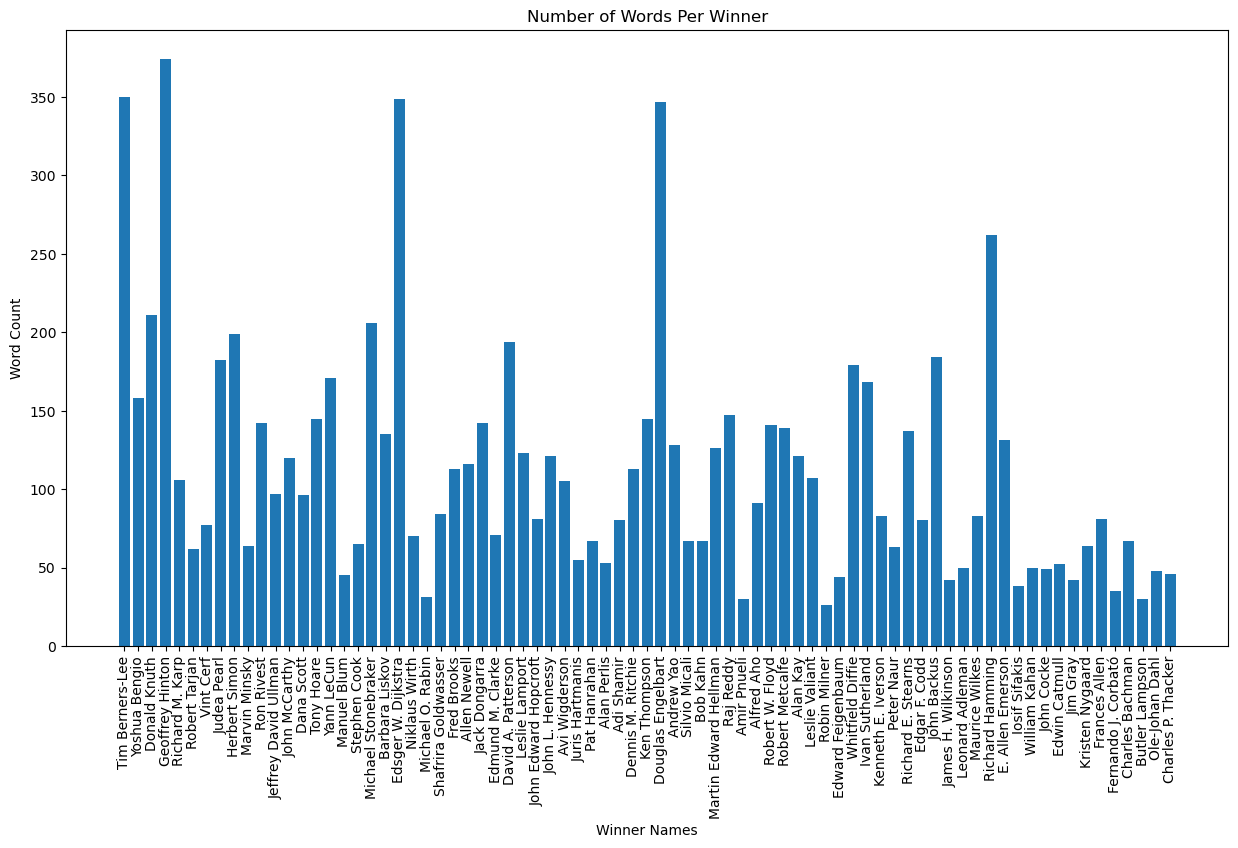

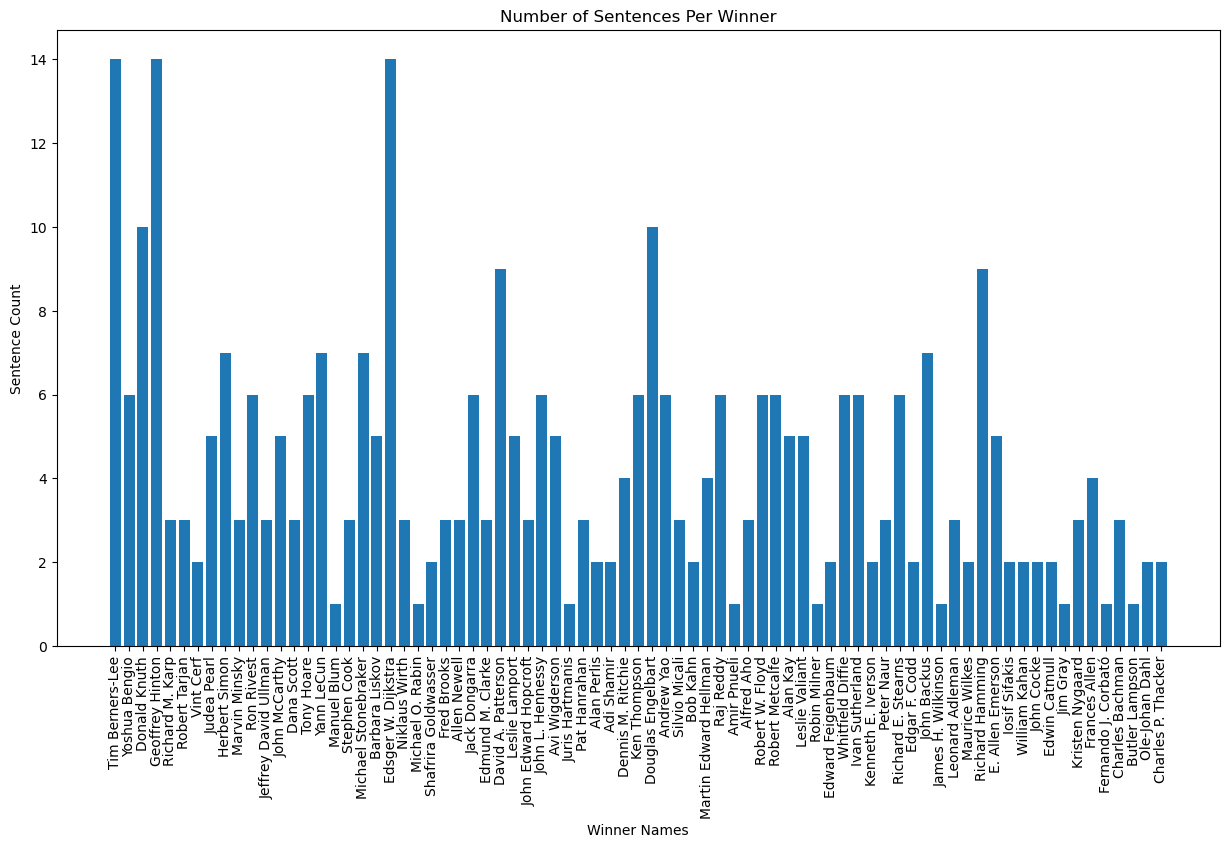

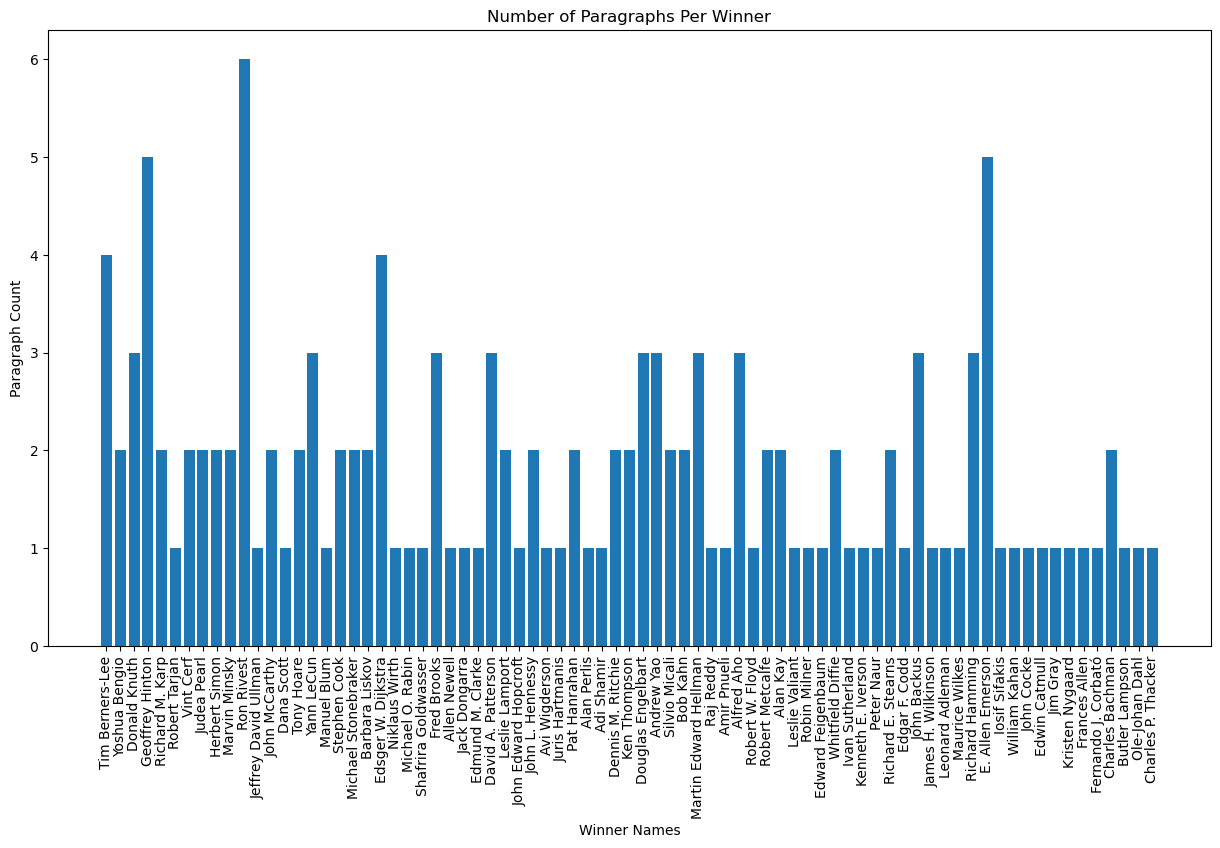

In [24]:
FIG_SIZE = (15,8)

winner_names = award_winners_intro["winner_name"]

word_counts = award_winners_intro["count_words"]
# Plot 1: Number of words per winner
plt.figure(figsize= FIG_SIZE)
plt.bar(winner_names, word_counts)
plt.title("Number of Words Per Winner")
plt.ylabel("Word Count")
plt.xlabel("Winner Names")
plt.xticks(rotation=90) # Added here for visibility of x-axis, else labels were all mixed up
plt.show()

sentence_counts = award_winners_intro["count_sentences"]
# Plot 2: Number of sentences per winner
plt.figure(figsize= FIG_SIZE)
plt.bar(winner_names, sentence_counts)
plt.title("Number of Sentences Per Winner")
plt.ylabel("Sentence Count")
plt.xlabel("Winner Names")
plt.xticks(rotation=90) # Added here for visibility of x-axis, else labels were all mixed up
plt.show()

paragraph_counts = award_winners_intro["count_paragraphs"]
# Plot 3: Number of paragraphs per winner
plt.figure(figsize=FIG_SIZE)
plt.bar(winner_names, paragraph_counts)
plt.title("Number of Paragraphs Per Winner")
plt.ylabel("Paragraph Count")
plt.xlabel("Winner Names")
plt.xticks(rotation=90) # Added here for visibility of x-axis, else labels were all mixed up
plt.show()

#### Task 15

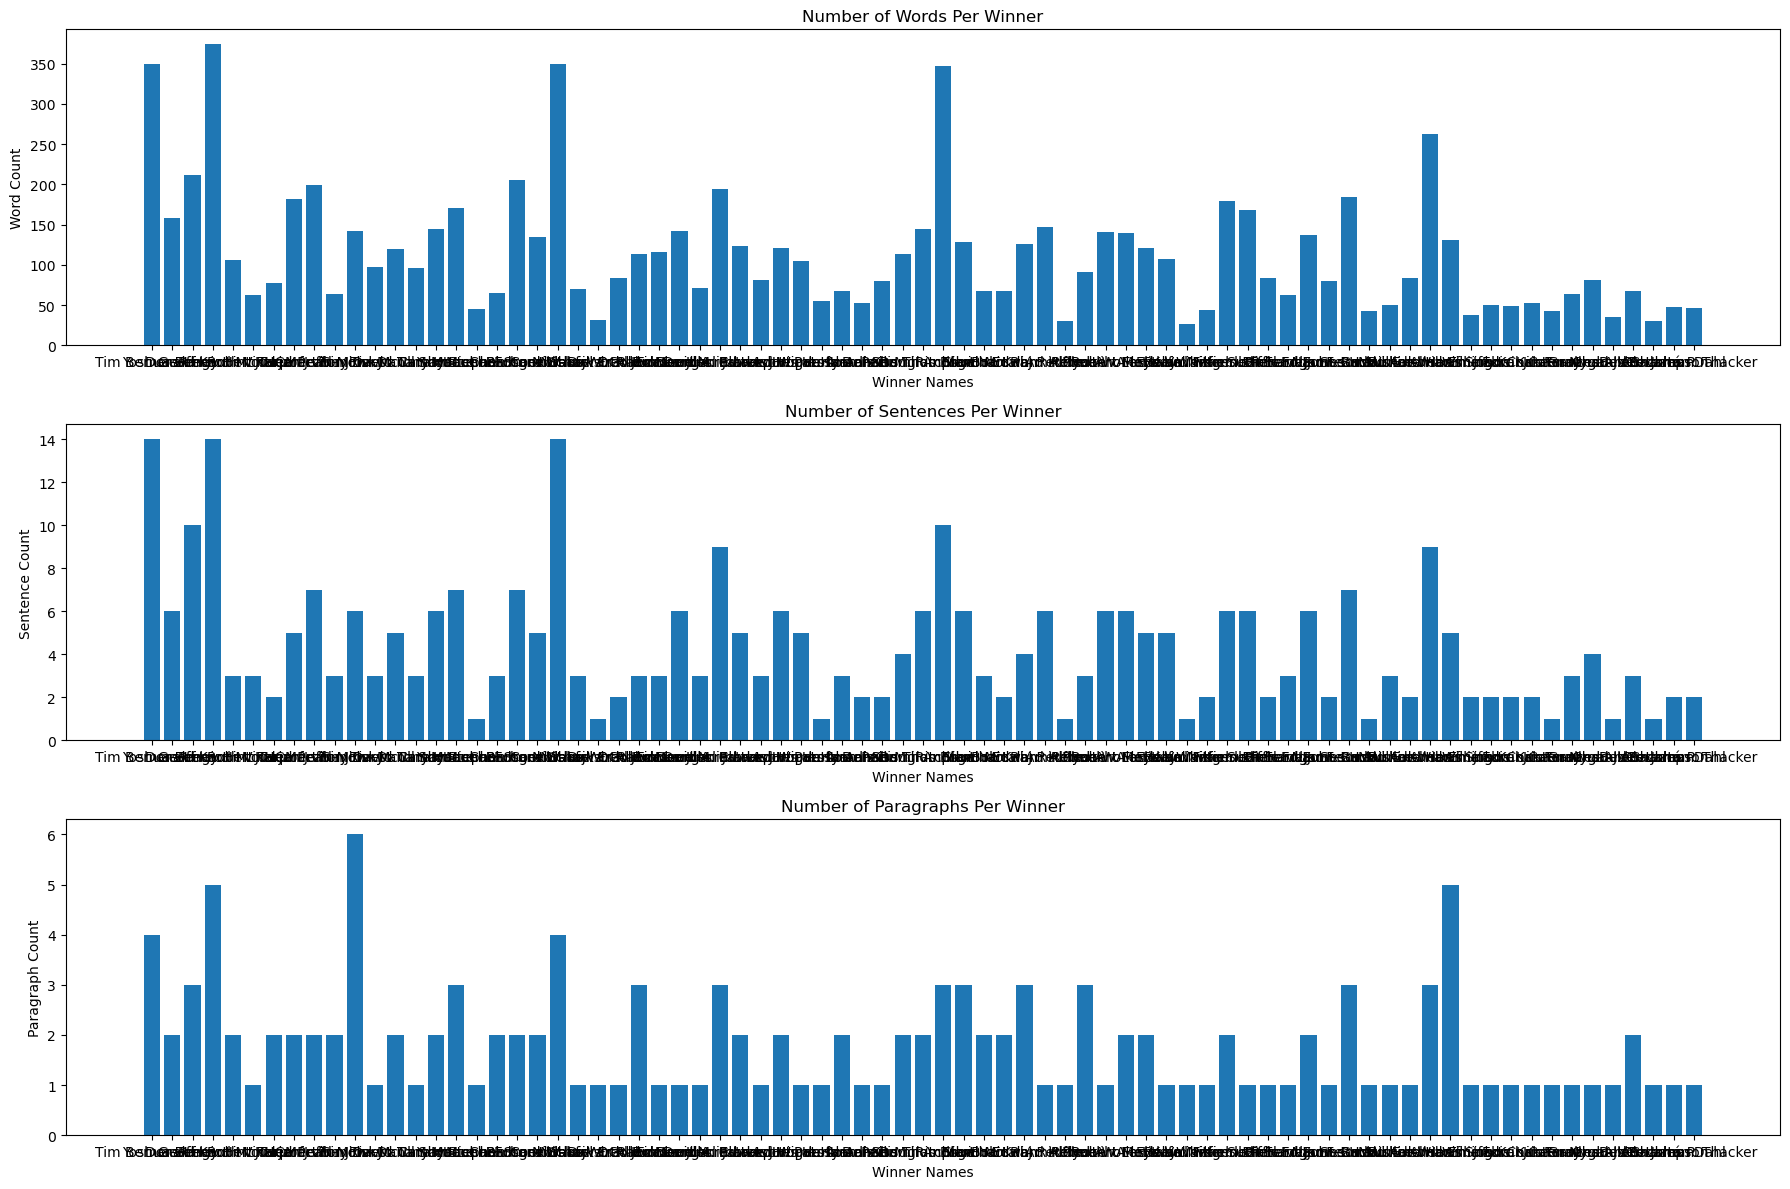

In [25]:
FIG_SIZE = (18, 12)

# Creating a single figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=FIG_SIZE)

# Plot 1: Number of words per winner
axes[0].bar(winner_names, word_counts)
axes[0].set_title("Number of Words Per Winner")
axes[0].set_ylabel("Word Count")
axes[0].set_xlabel("Winner Names")

# Plot 2: Number of sentences per winner
axes[1].bar(winner_names, sentence_counts)
axes[1].set_title("Number of Sentences Per Winner")
axes[1].set_ylabel("Sentence Count")
axes[1].set_xlabel("Winner Names")

# Plot 3: Number of paragraphs per winner
axes[2].bar(winner_names, paragraph_counts)
axes[2].set_title("Number of Paragraphs Per Winner")
axes[2].set_ylabel("Paragraph Count")
axes[2].set_xlabel("Winner Names")

# Adjusting layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()


#### Task 16

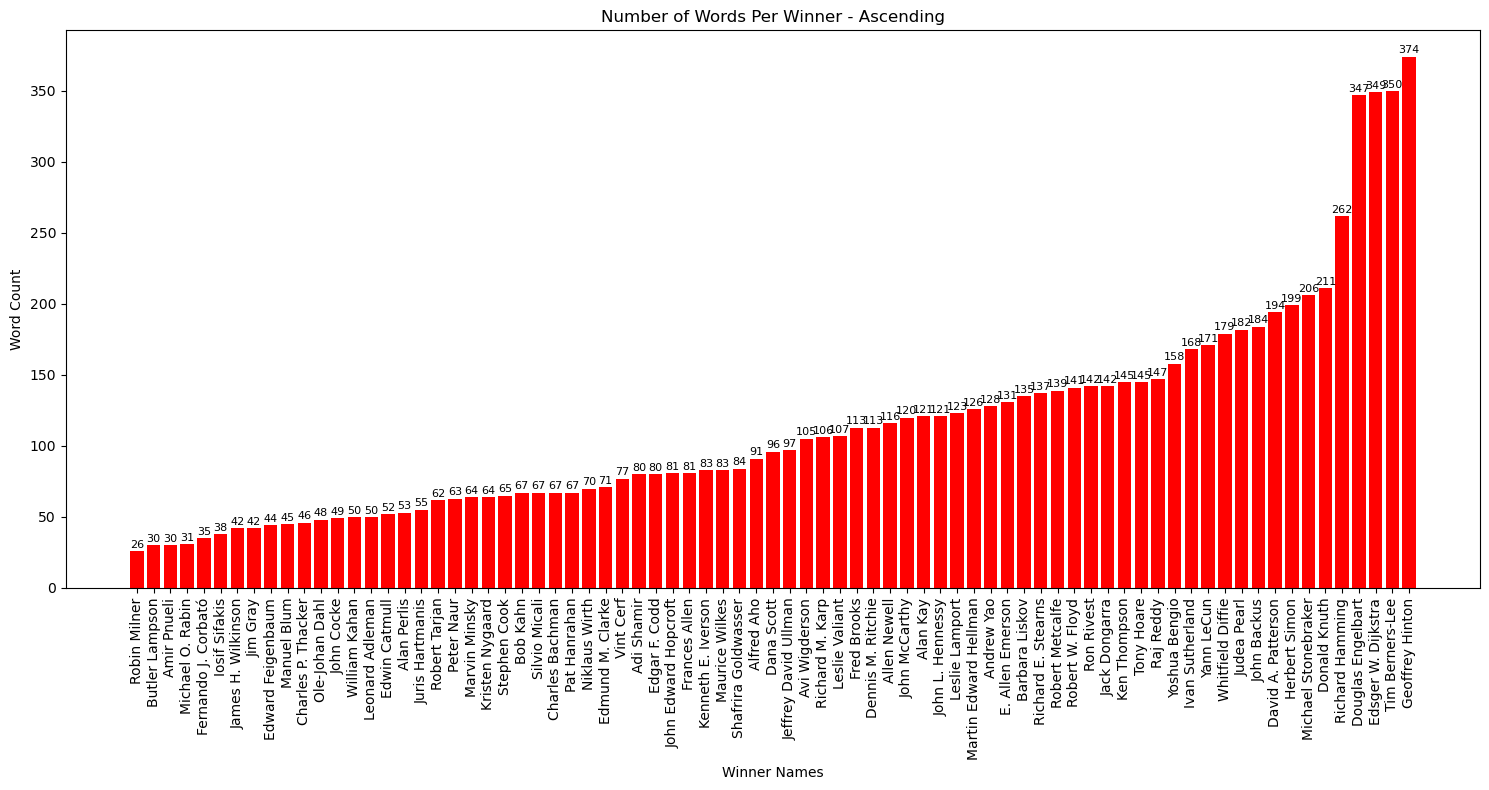

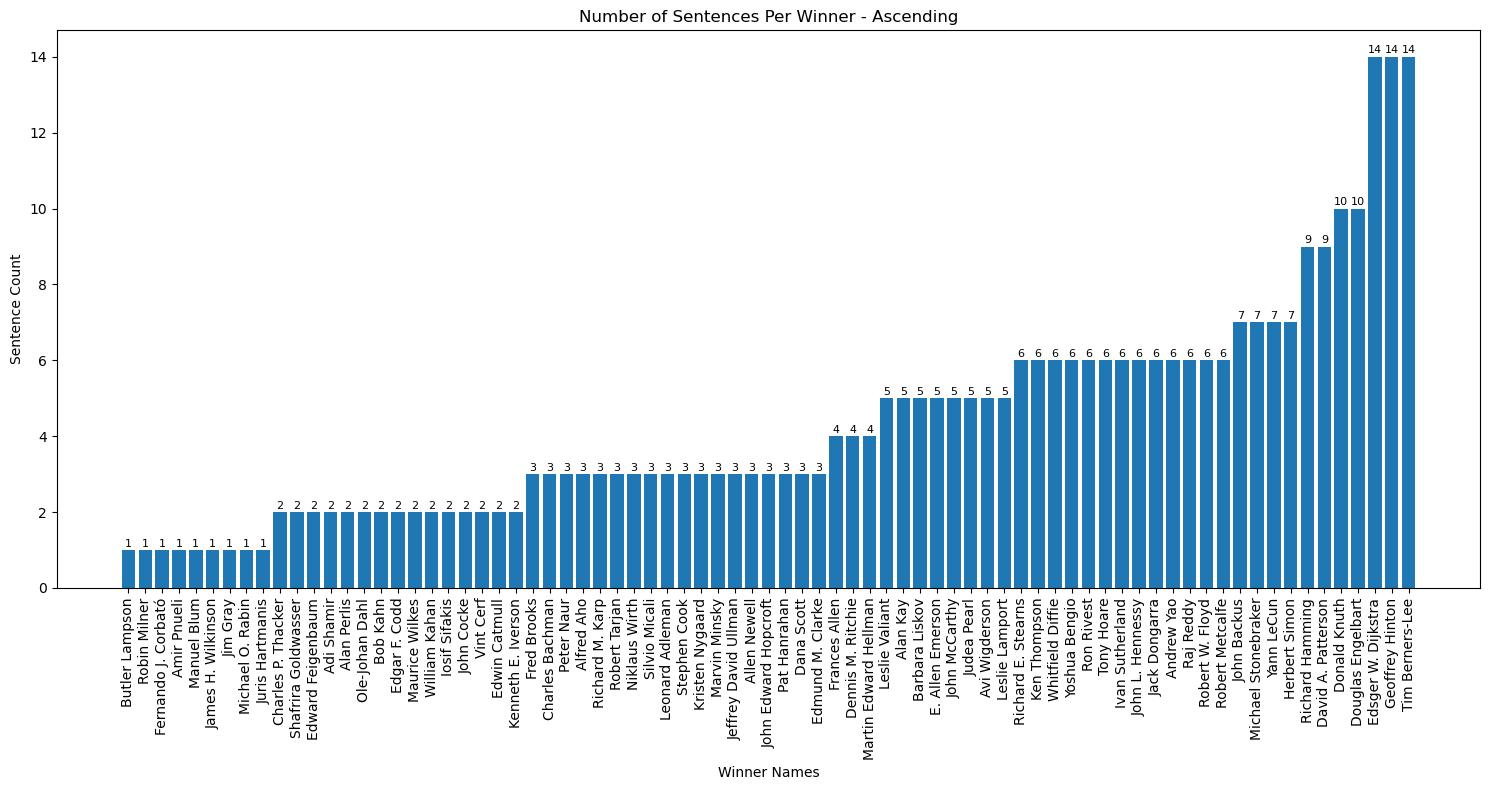

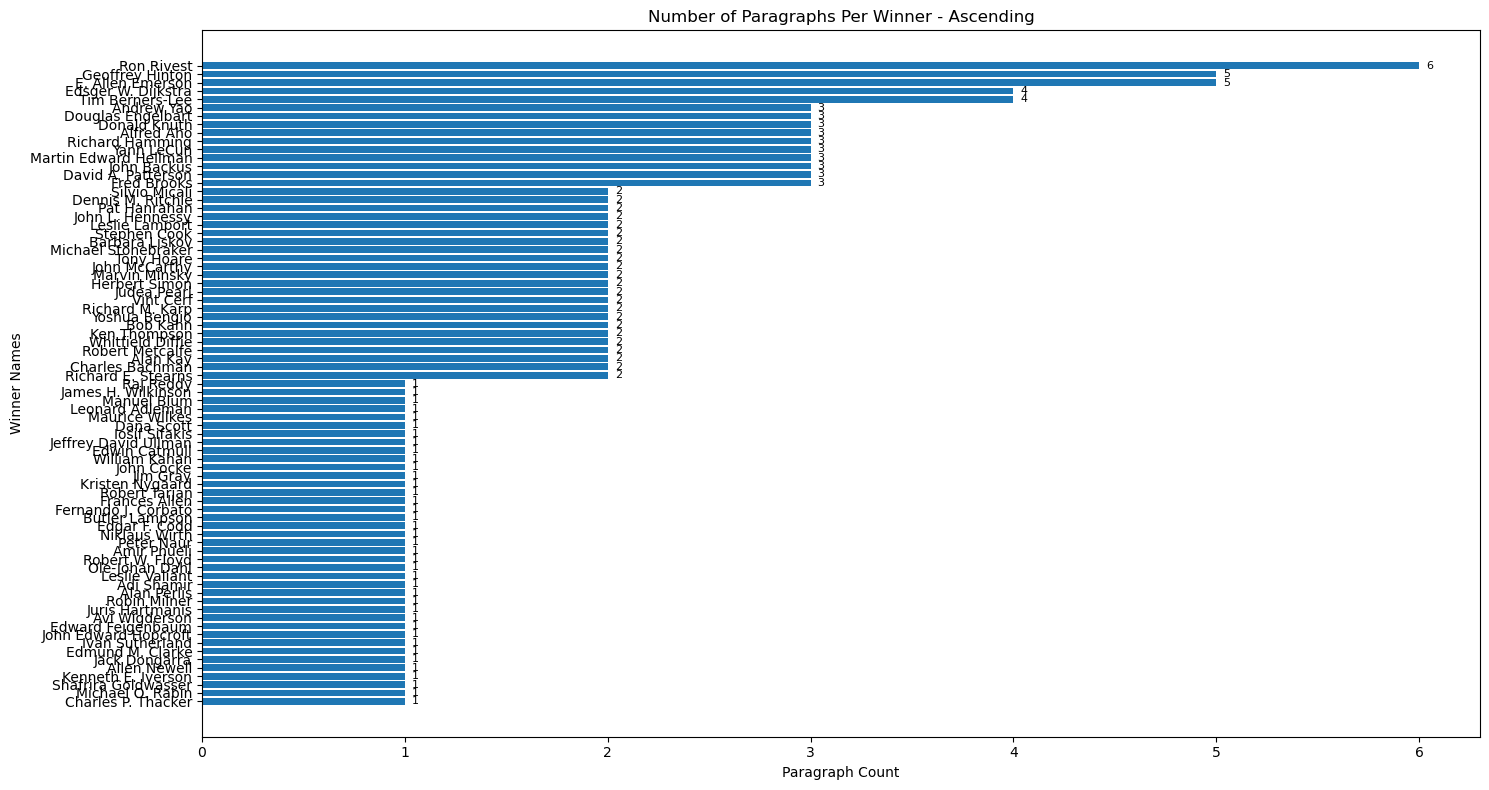

In [26]:
# Sorting the data for each plot in ascending order
sorted_word_data = award_winners_intro.sort_values(by="count_words")
sorted_sentence_data = award_winners_intro.sort_values(by="count_sentences")
sorted_paragraph_data = award_winners_intro.sort_values(by="count_paragraphs")

FIG_SIZE = (15, 8)

# Plot 1: Number of words per winner
plt.figure(figsize=FIG_SIZE)
bars = plt.bar(sorted_word_data["winner_name"], sorted_word_data["count_words"], color="red")
plt.title("Number of Words Per Winner - Ascending")
plt.xlabel("Winner Names")
plt.ylabel("Word Count")
plt.xticks(rotation=90)  # Rotating the x-axis labels 90 degrees clockwise
plt.bar_label(bars, padding=1, fontsize=8) # Adding labels on top of the bars
plt.tight_layout()
plt.show()

# Plot 2: Number of sentences per winner
plt.figure(figsize=FIG_SIZE)
bars = plt.bar(sorted_sentence_data["winner_name"], sorted_sentence_data["count_sentences"])
plt.title("Number of Sentences Per Winner - Ascending")
plt.xlabel("Winner Names")
plt.ylabel("Sentence Count")
plt.xticks(rotation=90) # Rotating the x-axis labels 90 degrees clockwise
plt.bar_label(bars, padding=1, fontsize=8) # Adding labels on top of the bars
plt.tight_layout()
plt.show()

# Plot 3: Horizontal bar plot for Number of paragraphs per winner
plt.figure(figsize=FIG_SIZE)
bars = plt.barh(sorted_paragraph_data["winner_name"], sorted_paragraph_data["count_paragraphs"])
plt.title("Number of Paragraphs Per Winner - Ascending")
plt.xlabel("Paragraph Count")
plt.ylabel("Winner Names")
plt.bar_label(bars, padding=5, fontsize=8) # Adding labels at the end of each bar
plt.tight_layout()
plt.show()